#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [ ]:
!which python

/usr/local/bin/python


# Install dependencies:

In [ ]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

In [ ]:
!pip install scikit-learn-extra

     |████████████████████████████████| 624kB 5.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=340341 sha256=f3ca59a1649128c4d425e06de0f64a8d45ee4a2c2f832f0bb7cdbd2150815b1d
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


# Imports

In [ ]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [ ]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

# Set pandas print options
This will improve readability of printed pandas dataframe.

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [ ]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [ ]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [ ]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [ ]:
embeddings

array([[-5.3245042e-02, -7.1353507e-03, -7.0758365e-02, ...,
         3.2801714e-02, -2.9693408e-02,  4.6543527e-02],
       [-9.1377059e-03, -8.2387756e-05,  8.6778486e-03, ...,
         5.4163843e-02, -3.4396667e-02,  5.8118351e-02],
       [-7.4134995e-03, -9.4089061e-02, -2.1700749e-02, ...,
         1.5641427e-02, -1.9658353e-02,  2.6446994e-02],
       ...,
       [ 1.0850568e-01, -3.7582509e-02,  3.3195000e-02, ...,
         2.4531085e-02,  1.7270682e-03, -5.7035822e-02],
       [-6.3811556e-02,  4.2347569e-02,  6.0809399e-03, ...,
        -3.3537280e-03,  2.9938709e-02, -8.7541193e-03],
       [-1.2884931e-02, -2.5499815e-03, -3.0545387e-02, ...,
         7.9958858e-03, -2.0350324e-02,  1.4002065e-02]], dtype=float32)

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [ ]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.54414934
n_clusters: 12 silhouette_avg: 0.35405076
n_clusters: 22 silhouette_avg: 0.2950542
n_clusters: 32 silhouette_avg: 0.28615388
n_clusters: 42 silhouette_avg: 0.2799053
n_clusters: 52 silhouette_avg: 0.27639922
n_clusters: 62 silhouette_avg: 0.2830038
n_clusters: 72 silhouette_avg: 0.289208
n_clusters: 82 silhouette_avg: 0.29315972
n_clusters: 92 silhouette_avg: 0.28408518
n_clusters: 102 silhouette_avg: 0.29110864
n_clusters: 112 silhouette_avg: 0.29720277
n_clusters: 122 silhouette_avg: 0.29336438
n_clusters: 132 silhouette_avg: 0.2916901
n_clusters: 142 silhouette_avg: 0.29777387
n_clusters: 152 silhouette_avg: 0.3084009
n_clusters: 162 silhouette_avg: 0.30348602
n_clusters: 172 silhouette_avg: 0.3057747
n_clusters: 182 silhouette_avg: 0.30624124
n_clusters: 192 silhouette_avg: 0.29835388
n_clusters: 202 silhouette_avg: 0.29424337
n_clusters: 212 silhouette_avg: 0.295551
n_clusters: 222 silhouette_avg: 0.29572174
n_clusters: 232 silhouette_avg: 

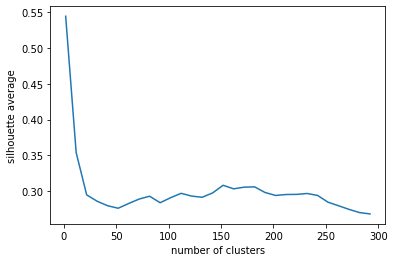

In [ ]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=300 
step=10 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [ ]:
number_of_clusters =  82
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 26     2
54     2
51     2
71     2
8      2
70     2
35     3
74     3
73     3
48     4
25     4
6      4
63     4
17     4
36     4
27     5
77     5
41     5
62     5
59     5
44     5
0      5
81     6
34     6
37     6
29     6
75     6
64     6
57     6
79     6
53     6
76     7
45     7
58     7
13     7
66     7
10     7
52     8
40     8
56     8
43     8
72     8
78     8
3      8
16     8
69     9
14     9
15     9
55    10
33    10
1     10
67    10
12    10
38    10
39    11
19    11
47    11
24    11
20    11
68    11
18    11
65    11
61    12
50    13
60    13
11    13
22    13
4     14
23    14
5     15
32    15
46    15
30    15
42    16
49    17
80    17
28    17
2     23
21    23
9     24
31    26
7     27
Name: label_kmedoids, dtype: int64


In [ ]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [ ]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

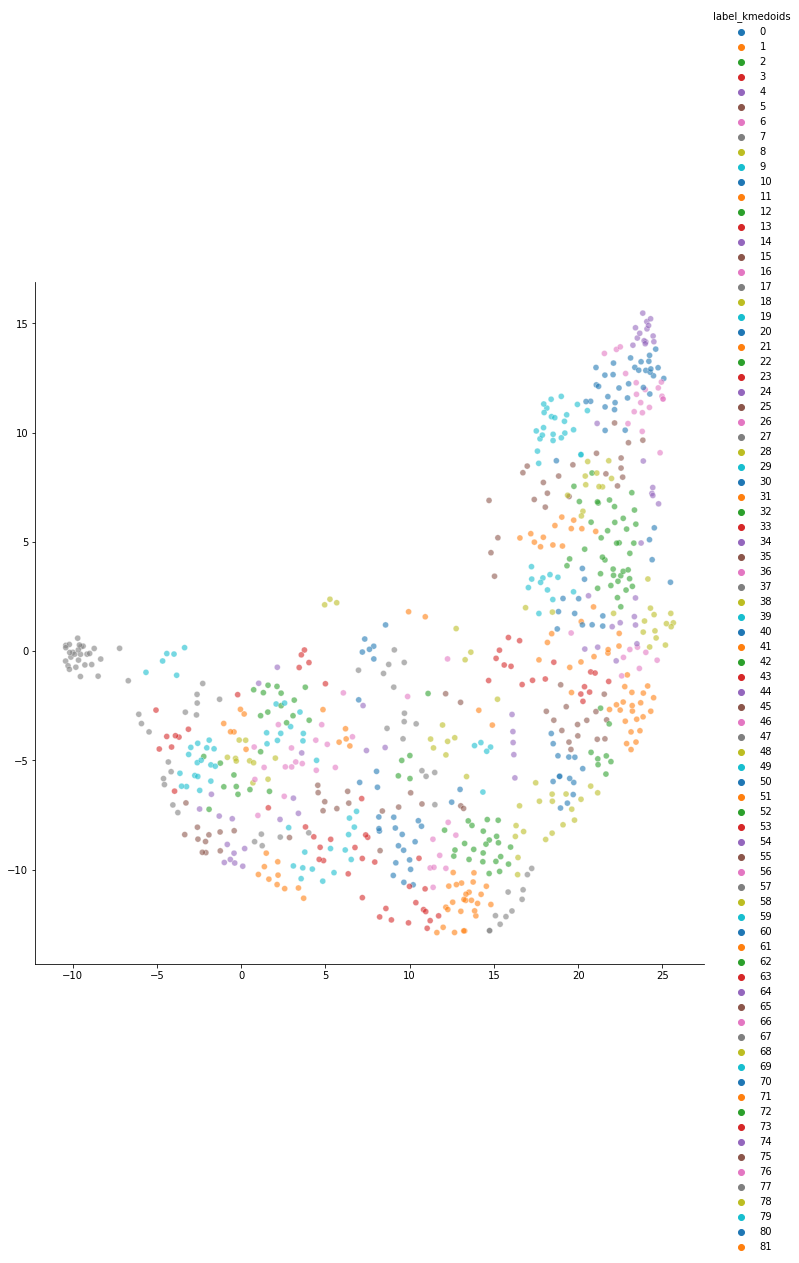

In [ ]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "tab10" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.59 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

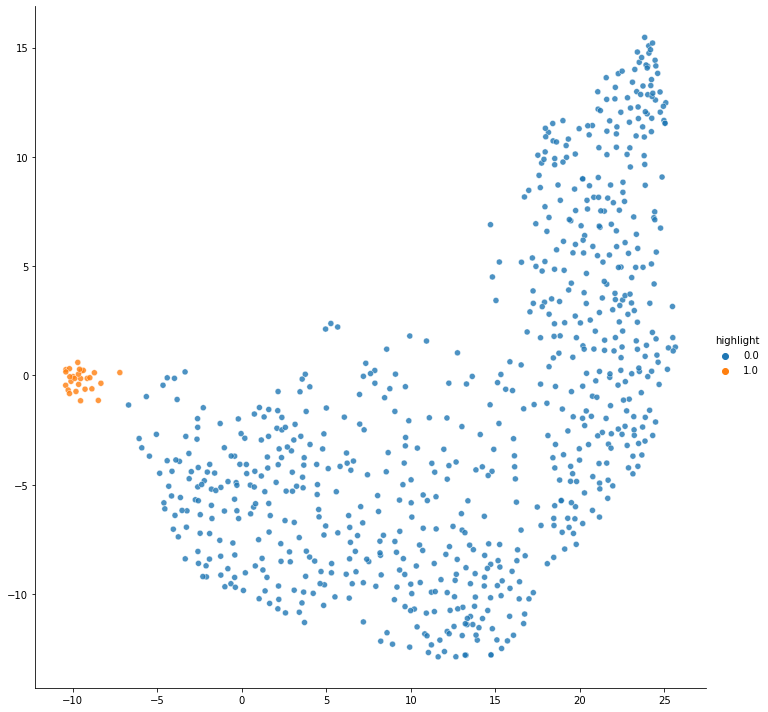

In [ ]:
## Choose a cluster to higlight:
cluster_num = 7 # as oppposed to 4 (longest vs shortest comments)
  
data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "tab10",alpha = 0.8,height = 10)


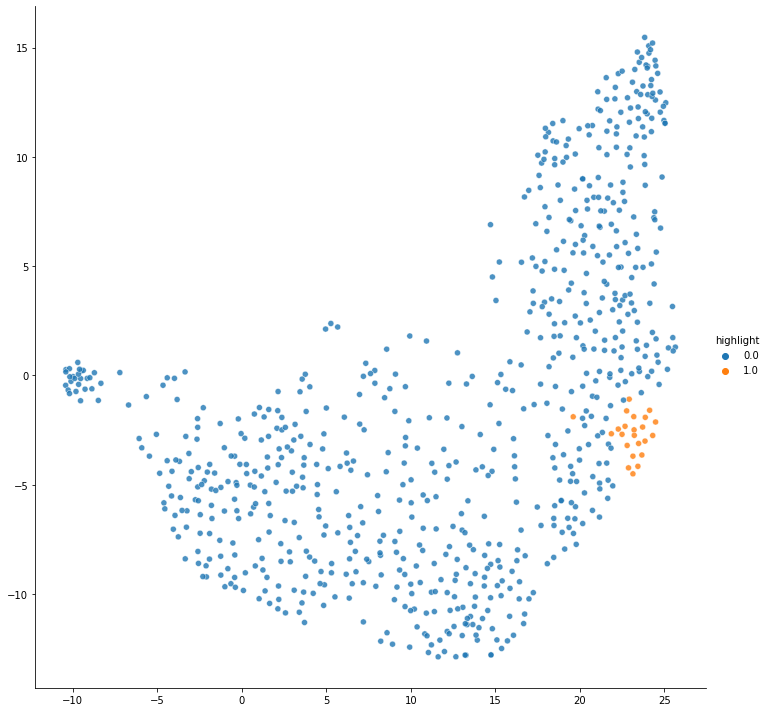

In [55]:
## Choose a cluster to higlight:
cluster_num = 21
  
data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "tab10",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [51]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
521,2019-02-22 17:03:26,graphicism,@Grant The AGW Smoking Gun -- https://www.americanthinker.com/articles/2010/02/the_agw_smoking_gun.html,1,@ The AGW Smoking Gun --\n\n\n,-1,0,0.000000e+00,0.0
677,2018-11-24 00:48:11,Tim Thompson,He's so many things that are embarrassing.,1,He's so many things that are embarrassing.\n\n,-1,1,5.960464e-08,0.0
323,2018-12-03 21:17:05,Christian Gasior,Someone who is probably sick of trump’s aggressive stupidity. How can you people not see that he has not even a basic grasp of issues he should be well versed in as commander in chief of the United States? We’re worried about being nice to this menace?,1,Someone who is probably sick of trump’s aggressive stupidity. How can you\npeople not see that he has not even a basic grasp of issues he should be well\nversed in as commander in chief of the United States? We’re worried about\nbeing nice to this menace?\n\n,-1,2,0.000000e+00,0.0
667,2018-12-07 00:19:06,Kingiux Kingas,U mean unidoctrinated.,1,U mean unidoctrinated.\n\n,-1,3,1.192093e-07,0.0
663,2019-01-02 09:08:31,D Marie333,"@Møssy Italy & France have best cheese! And the U.S. shootings are a strategic _cause_ for their desired _effect_ type of situation and that couldn't be more clear, many people are having, / have had project monarch screw up their brain in ways that most ppl couldnt even comprehend. Yes it is ABSOLUTELY real, I believe it was initiated as far back as the 60s and yes, it's very sad. We are ALSO rated as of now the #4 MOST DANGEROUS country for _journalists_ to travel (crazy...) and obviously the threat is not from regular civilians who are endangering anyone's saftey...( no matter what the ""official"" story says!) I also want to add, that Palestine, are the true VICTIMS of the highest mass shootings on inocent civilians currently and have been for far TOO long. Also, a law has been past in 24+states here that requires fed employees to sign a promise to not speak out against Israel and their war crimes as well as making it illegal to boycott any products or companies that are owned by the state of Israel. So we just lost another amendment right... we are not a free country anymore, and no one even knows it.... Yet.",1,"@ Italy & France have best cheese! And the U.S. shootings are a strategic\n_cause_ for their desired _effect_ type of situation and that couldn't be more\nclear, many people are having, / have had project monarch screw up their brain\nin ways that most ppl couldnt even comprehend. Yes it is ABSOLUTELY real, I\nbelieve it was initiated as far back as the 60s and yes, it's very sad. We are\nALSO rated as of now the #4 MOST DANGEROUS country for _journalists_ to travel\n(crazy...) and obviously the threat is not from regular civilians who are\nendangering anyone's saftey...( no matter what the ""official"" story says!) I\nalso want to add, that Palestine, are the true VICTIMS of the highest mass\nshootings on inocent civilians currently and have been for far TOO long. Also,\na law has been past in 24+states here that requires fed employees to sign a\npromise to not speak out against Israel and their war crimes as well as making\nit illegal to boycott any products or companies that are owned by the state of\nIsrael. So we just lost another amendment right... we are not a free country\nanymore, and no one even knows it.... Yet.\n\n",-1,4,1.192093e-07,1.0
233,2019-01-20 14:56:06,matsfreedom,"Climate change in a nutshell: politicians spending money they don&#39;t have on a problem that doesn&#39;t exist in order to fund solutions that make no difference. They want your money, folks. Trump gets it.",0,"Climate change in a nutshell: politicians spending money they don't have on a\nproblem that doesn't exist in order to fund solutions that make no difference.\nThey want your money, folks. Trump gets it.\n\n",-1,5,1.192093e-07,0.0
421,2019-08-09 23:27:59,JG Alegria,dude tha

In [ ]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  5 mean distance from center:  0.0014138221558823716 Proportion of replies: 100.0
1 number of samples:  10 mean distance from center:  0.0010895729246840347 Proportion of replies: 30.0
2 number of samples:  23 mean distance from center:  0.001632649036764633 Proportion of replies: 65.21739130434783
3 number of samples:  8 mean distance from center:  0.0011779367923736572 Proportion of replies: 75.0
4 number of samples:  14 mean distance from center:  0.0003584793603295111 Proportion of replies: 85.71428571428571
5 number of samples:  15 mean distance from center:  0.0016927719116210938 Proportion of replies: 53.333333333333336
6 number of samples:  4 mean distance from center:  0.0018522143363952637 Proportion of replies: 100.0
7 number of samples:  27 mean distance from center:  0.00044880089262733236 Proportion of replies: 74.07407407407408
8 number of samples:  2 mean distance from center:  0.001671910285949707 Proportion of replies: 50.0
9 number of samples:  2

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [54]:
# Choose a cluster to print
cluster_number =   21
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 23
Average Distance from cluster center: 1.3851601579517592e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
375,2018-11-14 18:28:42,graphicism,"He knows, you don't. AGW is BS.",1,"He knows, you don't. AGW is BS.\n\n",-1,21,0.000000,0.0
155,2019-04-25 22:42:13,Ashley Carr,"He should just say humans! I heard him beating around the Bush, doesnt seem to know shit about global warming. Very disapointing!",0,"He should just say humans! I heard him beating around the Bush, doesnt seem to\nknow shit about global warming. Very disapointing!\n\n",-1,21,0.000006,0.0
43,2020-08-21 18:10:53,Pluff io,"&quot;Climate change, I dont know him too well. I havent herd the full story but I wish him well.&quot;",0,"""Climate change, I dont know him too well. I havent herd the full story but I\nwish him well.""\n\n",-1,21,0.000007,0.0
39,2020-08-22 20:38:00,vj rn,"The guy basically doesn&#39;t care or know anything about climate change<br />he&#39;s underestimating how much pollution humans have created, just like how he underestimated the corona virus <br />how did we end up here",0,"The guy basically doesn't care or know anything about climate change \nhe's underestimating how much pollution humans have created, just like how he\nunderestimated the corona virus \nhow did we end up here\n\n",-1,21,0.000008,0.0
172,2019-04-25 17:30:12,fatmanturkey,Ben Wilde but he’s not saying that climate change isn’t real no?,1,but he’s not saying that climate change isn’t real no?\n\n,-1,21,0.000009,0.0
141,2019-05-29 14:53:16,Agshin Yusifzada,He knows that there is climate change but he doesnt want to lose his money.,0,He knows that there is climate change but he doesnt want to lose his money.\n\n,-1,21,0.000009,0.0
388,2018-11-10 23:31:13,ᗯⲁɳⲧⲈqᥙ8s2Ⲛⲉⲉᕍ,So he&#39;s been seen &amp; heard stating in interviews that he doesn&#39;t think that climate change is real &amp; then he turns around in another interview &amp; states that he agrees that humans have contributed to climate change. This is so typical of him.,0,So he's been seen & heard stating in interviews that he doesn't think that\nclimate change is real & then he turns around in another interview & states\nthat he agrees that humans have contributed to climate change. This is so\ntypical of him.\n\n,-1,21,0.000009,0.0
53,2020-08-17 04:12:02,Defendor,men AND women contribute to climate change. You heard it from him first,0,men AND women contribute to climate change. You heard it from him first\n\n,-1,21,0.000010,0.0
183,2019-03-23 06:00:17,Samcooksk8er,Did he just say that climate change will reverse?!?!?!?! U got to b kidding me!,0,Did he just say that climate change will reverse?!?!?!?! U got to b kidding\nme!\n\n,-1,21,0.000010,0.0
136,2019-06-09 07:31:25,Ayub M,"for once i agree with him, climate change is a hoax! if it were real, governments would be racing for it like they are with all other things.",0,"for once i agree with him, climate change is a hoax! if it were real,\ngovernments would be racing for it like they are with all other things.\n\n",-1,21,0.000011,0.0


# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [58]:
#which cluster would you like to assign labels to?
cluster_number = 21
#your label
label_manual = 'HE_The_dude'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [60]:
data[data['label_kmedoids']==7].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
157,2020-09-17 00:14:44,L TINGS,Stephen Bryant nooooo,1,nooooo\n\n,longComments,7,0.000000e+00,0.0
336,2019-08-09 23:40:54,JG Alegria,incorrect,1,incorrect\n\n,longComments,7,5.364418e-07,0.0
419,2018-11-06 18:54:14,Ben Fullagar,Wanker,0,Wanker\n\n,longComments,7,1.072884e-06,0.0
106,2019-12-11 18:19:16,Javier Hermosilla,Source?,1,Source?\n\n,longComments,7,1.370907e-06,0.0
201,2019-05-20 17:24:31,DogAte MyPlums,@Eugene DeVito brainwashed,1,@ brainwashed\n\n,longComments,7,1.370907e-06,0.0
328,2019-06-08 01:31:05,OBAMA ALBINO,@Gwen Minor 🙄🙄,1,@ 🙄🙄\n\n,longComments,7,2.026558e-06,0.0
46,2020-08-21 15:24:59,Baldi Locks,🤦🏻‍♂️,0,🤦🏻‍♂️\n\n,longComments,7,2.086163e-06,0.0
58,2020-08-06 18:16:47,Haus of RicoBHI,Bollutants?,0,Bollutants?\n\n,longComments,7,2.145767e-06,0.0
118,2020-08-05 15:14:47,Tyler Bowers,Nah,1,Nah\n\n,longComments,7,2.145767e-06,0.0
278,2020-08-24 21:48:58,danny marcinek,Russia,1,Russia\n\n,longComments,7,2.205372e-06,0.0
